# Preprocess & Embed Text

In [5]:
# pip install keras-tuner
!pip install -q keras-tuner

In [6]:
# Import imblearn to use SMOTE
!pip install -q imbalanced-learn

In [7]:
# Import our dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import joblib
import pickle
import torch
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Read in the fake_job_postings.csv
fake_job_df = pd.read_csv("/content/fake_job_postings.csv")

fake_job_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
# Create a short dataframe
short_df = fake_job_df
short_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
# Remove rows where 'description' or 'industry' is null from short_df
short_df = short_df.dropna(subset=['description', 'industry'])
print(short_df.shape)

(12977, 18)


In [11]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [13]:
# Apply preprocessing
short_df['cleaned_text'] = short_df['description'].apply(preprocess_text)

<ipython-input-13-05cd7295589f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['cleaned_text'] = short_df['description'].apply(preprocess_text)


In [14]:
# Load DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [15]:
# Define BERT embedding function
def get_bert_embedding(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return np.zeros((768,))
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()
    except Exception as e:
        print(f"Error processing text: {text[:30]}... — {e}")
        return np.zeros((768,))

In [16]:
# Generate BERT embeddings
bert_features = np.vstack(short_df['cleaned_text'].apply(get_bert_embedding).values)

# Define labels
y = short_df["fraudulent"]


In [18]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'industry' column
industry_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
industry_encoded = industry_ohe.fit_transform(short_df[['industry']])

# Combine BERT features with industry encoding
X_combined = np.hstack((bert_features, industry_encoded))


In [21]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)


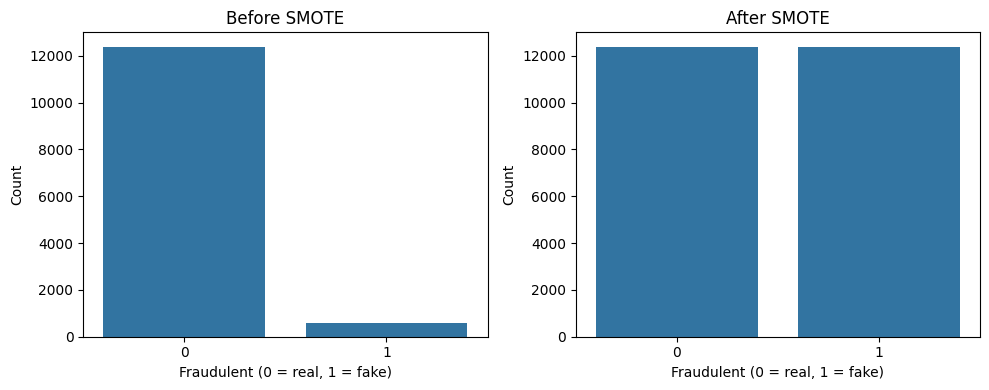

In [22]:
# Visualize class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Before SMOTE")
plt.xlabel("Fraudulent (0 = real, 1 = fake)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title("After SMOTE")
plt.xlabel("Fraudulent (0 = real, 1 = fake)")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()

In [23]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train logistic regression on BERT features
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2516
           1       0.91      0.95      0.93      2439

    accuracy                           0.93      4955
   macro avg       0.93      0.93      0.93      4955
weighted avg       0.93      0.93      0.93      4955



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# Save model
joblib.dump(model, 'logistic_model_bert.joblib')

['logistic_model_bert.joblib']

In [25]:
# TF-IDF path
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(short_df["cleaned_text"])

# Redefine target for TF-IDF
y_tfidf = short_df["fraudulent"]

In [26]:
# Chi-squared red-flag words
chi2_scores, _ = chi2(X_tfidf, y_tfidf)
feature_names = np.array(vectorizer.get_feature_names_out())
top_indices = np.argsort(chi2_scores)[::-1][:100]
red_flag_words = feature_names[top_indices]

print(red_flag_words)

['aker' 'ultra luxury' 'ultra' 'aker solution' 'oil gas' 'gas industry'
 'subsea' 'cruise' 'petroleum' 'gas' 'provider product' 'global provider'
 'oil' 'urlfafceadeaecaedbdfefaae' 'production maximize'
 'employ approximately' 'discovery production' 'recovery petroleum'
 'urlfafceadeaecaedbdfefaae information' 'bring discovery'
 'petroleum field' 'industry engineering' 'field employ' 'country go'
 'go urlfafceadeaecaedbdfefaae' 'overviewaker solution' 'overviewaker'
 'maximize recovery' 'service oil' 'corporate overviewaker'
 'approximately people' 'people country' 'global oil' 'hse' 'within aker'
 'technology bring' 'information business' 'individual prepared'
 'industry face' 'business people' 'also position' 'product system'
 'prepared take' 'data entry' 'position exciting' 'solution also'
 'system service' 'tax free' 'take position' 'challenge global'
 'position within' 'solution global' 'earnings' 'position entrepreneurial'
 'clerical' 'administrative assistant' 'clerk' 'help achi

In [27]:
# Save red-flag words
red_flag_df = pd.DataFrame({"word": red_flag_words})
red_flag_df.to_csv("red_flag_words.csv", index=False)
red_flag_df.to_csv("/content/drive/MyDrive/red_flag_words.csv", index=False)


In [28]:
# Train/test split for TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

# Train logistic regression on TF-IDF
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression()

In [29]:
# Save model/vectorizer
joblib.dump(model_tfidf, 'logistic_model_tfidf.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [30]:
# Predict and report
preds_tfidf = model_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, preds_tfidf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2469
           1       0.96      0.20      0.34       127

    accuracy                           0.96      2596
   macro avg       0.96      0.60      0.66      2596
weighted avg       0.96      0.96      0.95      2596



In [31]:
# Keyword insight function
def show_top_keywords(index):
    tfidf_values = X_test_tfidf[index].toarray().flatten()
    keyword_scores = list(zip(feature_names, tfidf_values))
    keyword_scores = sorted(keyword_scores, key=lambda x: x[1], reverse=True)
    print(f"Top keywords for test sample #{index}:")
    for keyword, score in keyword_scores[:10]:
        print(f"- {keyword}: {score:.4f}")
    print(f"Model Prediction: {preds_tfidf[index]} (0 = not fraudulent, 1 = fraudulent)")
    print("-" * 50)

for i in range(3):
    show_top_keywords(i)



Top keywords for test sample #0:
- recruitment: 0.3482
- career: 0.1681
- minded please: 0.1571
- motivated career: 0.1535
- leaversthis fantastic: 0.1531
- leaversthis: 0.1520
- school leaversthis: 0.1520
- available year: 0.1516
- funding available: 0.1516
- role school: 0.1513
Model Prediction: 0 (0 = not fraudulent, 1 = fraudulent)
--------------------------------------------------
Top keywords for test sample #1:
- engine: 0.4188
- search engine: 0.3753
- search: 0.3062
- marketing strategy: 0.2440
- strategy: 0.2431
- google: 0.2239
- adwords: 0.1977
- advertising: 0.1967
- online marketing: 0.1770
- marketing: 0.1748
Model Prediction: 0 (0 = not fraudulent, 1 = fraudulent)
--------------------------------------------------
Top keywords for test sample #2:
- wed like: 0.2775
- team opportunity: 0.2645
- developer: 0.2626
- developer work: 0.2587
- florida: 0.2551
- software developer: 0.2465
- wed: 0.2280
- talk: 0.2197
- thats: 0.2043
- everything: 0.1972
Model Prediction: 0 (0 

In [32]:
# Save features and labels
with open("X.pickle", "wb") as f:
    pickle.dump(short_df['description'], f)
with open("y.pickle", "wb") as f:
    pickle.dump(y, f)


In [33]:
# Save short_df to CSV locally
short_df.to_csv('short_df.csv', index=False)

# Save short_df directly to Google Drive
short_df.to_csv('/content/drive/MyDrive/short_df.csv', index=False)